# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os 
import glob as gb 
from tqdm.auto import tqdm

import torch 
import torch.nn as nn 
from torch.optim import Adam 
import torchvision 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader , Dataset
from torchvision.utils import make_grid

# Loading dataset

In [2]:
IMG_SIZE = 256
IMGS_DIR = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
MASKS_DIR = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks"

In [3]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [4]:
class CustomData(Dataset) : 
    def __init__(self) : 
        self.img_paths = sorted(gb.glob(os.path.join(IMGS_DIR , '*')))
        self.mask_paths = sorted(gb.glob(os.path.join(MASKS_DIR , '*')))
        self.transform = transforms.Compose([
            transforms.Resize(size = (IMG_SIZE , IMG_SIZE)) , 
            ToTensor() , 
            transforms.CenterCrop(IMG_SIZE),
            transforms.Normalize([0.5], [0.5])
        ])
        if len(self.img_paths) != len(self.mask_paths) : 
            raise InvalidDatasetException(self.img_paths , self.mask_paths)
            
            
    def __len__(self) : 
        return len(self.img_paths)
    
    
    def __getitem__(self , idx) : 
        img = Image.fromarray(cv2.cvtColor(cv2.imread(self.img_paths[idx]) , cv2.COLOR_BGR2RGB))
        tensor_img = self.transform(img)
        
        mask = Image.open(self.mask_paths[idx])
        tensor_mask = self.transform(mask)
        
        return tensor_img , tensor_mask

In [5]:
dataset = CustomData()

In [6]:
print(f"The total number of samples in the dataset is : {dataset.__len__()}")

The total number of samples in the dataset is : 10192


# Create Dataloaders

In [7]:
BATCH_SIZE = 32

In [8]:
dataset_dataloader = DataLoader(
    dataset = dataset , 
    batch_size = BATCH_SIZE , 
    shuffle = True
)

In [9]:
print(f"the size of the dataloader {len(dataset_dataloader)} batches of {BATCH_SIZE}")

the size of the dataloader 319 batches of 32


In [10]:
img_sample , mask_sample= next(iter(dataset_dataloader))
img_sample.shape , mask_sample.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 3, 256, 256]))

# Samples of images of people with Normal Lung

In [11]:
def plot_samples(images, titles):
    fig, axs = plt.subplots(3, 8, figsize=(16, 8))
    axs = axs.flatten()

    for i in range(24):
        img = images[i].numpy()
        img = np.transpose(img , (1,2,0))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(titles[i])
        

    plt.tight_layout()
    plt.show()

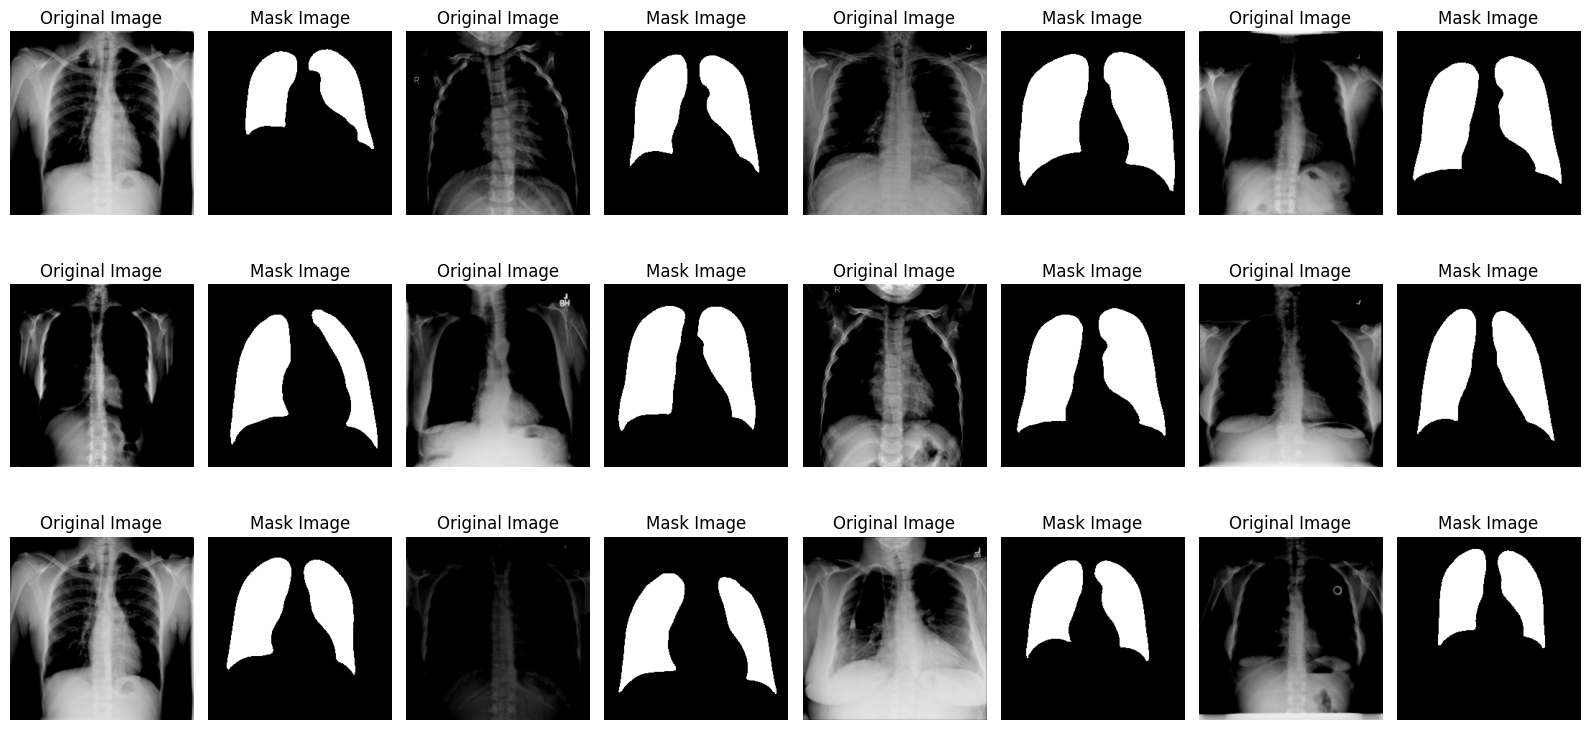

In [12]:
random_indices = np.random.randint(0, len(img_sample), 24)

random_images = []
titles = []

for i, index in enumerate(random_indices):
    if i % 2 == 0:
        random_images.append(img_sample[index])
        titles.append("Original Image")
    else:
        random_images.append(mask_sample[index])
        titles.append("Mask Image")

plot_samples(random_images, titles)

# Build our model

In [13]:
def param_count(model , model_name):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'The Total number of parameters in the {model_name} model : {sum(params)}')

In [14]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


**The Discriminator**

In [15]:
class Discriminator(nn.Module) : 
    def __init__(self , in_channels = 3) : 
        super().__init__() 
        self.block = nn.Sequential(
            self.disc_block(in_channels*2 , 64 , initial_layer=True) , 
            self.disc_block(64 , 128) , 
            self.disc_block(128 , 256) , 
            self.disc_block(256 , 512) , 
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )
        
        
    def disc_block(self , input_channels , output_channels , initial_layer=False) : 
        if not initial_layer : 
            return nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.LeakyReLU(0.2)
            )
        
        else : 
            return nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 ,
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) ,  
                nn.LeakyReLU(0.2)
            )
        
    def forward(self , img0 , img1) : 
        img_input = torch.cat((img0 , img1) , dim= 1) 
        return self.block(img_input)

**The Generator**

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_channels , output_channels , norm_layer = False , use_dropout=False):
        super().__init__()
        if not norm_layer : 
            self.block = nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.LeakyReLU(0.2)
            )
        
        else : 
            self.block = nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 ,
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) ,  
                nn.LeakyReLU(0.2)
            )
            
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.block(x)
        
        return self.dropout(x) if self.use_dropout else x

In [17]:
class Decoder(nn.Module):
    def __init__(self, input_channels , output_channels , use_dropout=False):
        super().__init__()
        self.block = nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.ReLU(inplace=True)
        )
            
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x , skip_connection) :
            x = self.block(x) 
            x = torch.cat((x , skip_connection) , dim = 1)
            
            return self.dropout(x) if self.use_dropout else x

In [18]:
class Generator(nn.Module) : 
    def __init__(self , in_channels = 3 , out_channels = 3) : 
        super().__init__() 
        
        # encoder 
        self.down1 = Encoder(in_channels , 64 , norm_layer = True)
        self.down2 = Encoder(64 , 128)
        self.down3 = Encoder(128 , 256)
        self.down4 = Encoder(256 , 512 , use_dropout=True)
        self.down5 = Encoder(512 , 512 , use_dropout=True)
        self.down6 = Encoder(512 , 512 , use_dropout=True)
        self.down7 = Encoder(512 , 512 , use_dropout=True)
        self.down8 = Encoder(512 , 512 , norm_layer = True , use_dropout=True)
        
        
        # decoder 
        self.up1 = Decoder(512 , 512 , use_dropout=True)
        self.up2 = Decoder(1024 , 512 , use_dropout=True)
        self.up3 = Decoder(1024 , 512 , use_dropout=True)
        self.up4 = Decoder(1024 , 512 , use_dropout=True)
        self.up5 = Decoder(1024, 256)
        self.up6 = Decoder(512, 128)
        self.up7 = Decoder(256, 64)
        
        self.final_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final_conv(u7)

In [19]:
disc_model = Discriminator().to(device)
gen_model = Generator().to(device)

In [20]:
param_count(disc_model , 'Discriminator')

The Total number of parameters in the Discriminator model : 2768640


In [21]:
param_count(gen_model , 'Generator')

The Total number of parameters in the Generator model : 54413955


# Train our model

In [22]:
def show_tensor_images(image_tensor, num_images=15):

    image_tensor = image_tensor * 0.5 + 0.5
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=3)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

In [23]:
disc_optimizer = Adam(disc_model.parameters() , lr = 0.0002, betas=(0.5 , 0.999))
gen_optimizer = Adam(gen_model.parameters() , lr = 0.0002 , betas=(0.5 , 0.999))
criterion = nn.BCEWithLogitsLoss() 
criterion_pixelwise = nn.L1Loss() 
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
lambda_pixel = 100
Epochs = 20 

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/20] [Disc loss: 0.458639] [Gen loss: 3.093687]


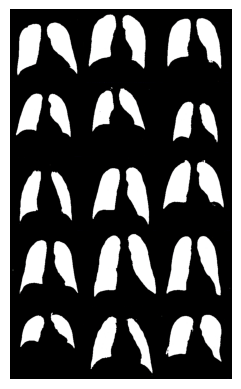

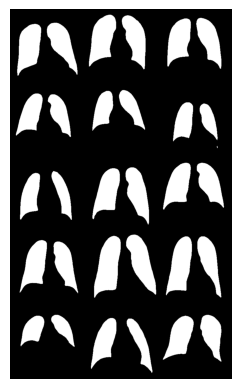

[Epoch 20/20] [Disc loss: 0.013788] [Gen loss: 9.340494]


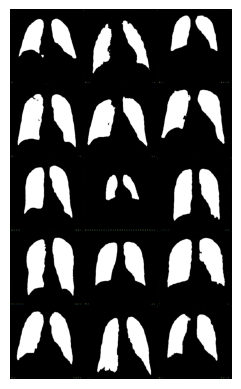

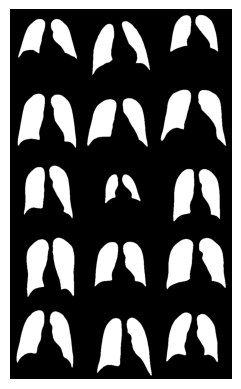

In [24]:
for i in tqdm(range(Epochs)) : 
    for img , mask in dataset_dataloader : 
        img , mask = img.to(device) , mask.to(device) 
        
        # updata discriminator 
        with torch.cuda.amp.autocast() : 
            fake = gen_model(img)
            
            disc_fake_pred = disc_model(img , fake.detach()) 
            disc_real_pred = disc_model(img , mask) 
            
            disc_fake_loss = criterion(disc_fake_pred , torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred , torch.ones_like(disc_real_pred))
            
            disc_loss = (disc_fake_loss + disc_real_loss) / 2 
            
        disc_model.zero_grad()
        d_scaler.scale(disc_loss).backward()
        d_scaler.step(disc_optimizer)
        d_scaler.update()
        
        
        # update Generator 
        with torch.cuda.amp.autocast() : 
            fake2 = gen_model(img) 
            gen_fake_pred = disc_model(img , fake2) 
            
            gen_fake_loss = criterion(gen_fake_pred , torch.ones_like(gen_fake_pred)) 
            
            gen_pixelwise_loss = criterion_pixelwise(fake2 , mask) * lambda_pixel
            
            gen_loss = gen_fake_loss + gen_pixelwise_loss
            
        gen_optimizer.zero_grad() 
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(gen_optimizer) 
        g_scaler.update() 
        
    
    if (i+1) % 10 == 0 : 
        print(
                "[Epoch %d/%d] [Disc loss: %f] [Gen loss: %f]"
                % (i+1, Epochs , disc_loss.item(), gen_loss.item())
            )
        
        show_tensor_images(gen_model(img))
        show_tensor_images(mask)

# Save our model 

In [25]:
torch.save(gen_model.state_dict(), 'COVID-19 Radiography Gen Model.pt')

In [26]:
torch.save(disc_model.state_dict(), 'COVID-19 Radiography Disc Model.pt')